In [1]:
import pandas as pd
import numpy as np 
import json
import os
import re

In [2]:
read = pd.read_json("raw/out_label/summaries_out3.json", lines = True)
df = read[read.answer == "accept"]
df.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,Ukraine war: Russian tactics on eastern front ...,0,1192826571,1725000051,False,"[{'start': 0, 'end': 7, 'token_start': 0, 'tok...","[{'text': 'Ukraine', 'start': 0, 'end': 7, 'id...",relations,"[{'head': 3, 'child': 0, 'head_span': {'start'...",accept,1666853824
2,Lee Jae-yong: Samsung appoints Lee Jae-yong to...,2,-386898449,495824270,False,"[{'start': 0, 'end': 12, 'token_start': 0, 'to...","[{'text': 'Lee', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 31, 'child': 18, 'head_span': {'star...",accept,1666854104
3,New Zealand Instagram couple 'relieved' after ...,3,94784817,-1047716132,False,"[{'start': 0, 'end': 28, 'token_start': 0, 'to...","[{'text': 'New', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 3, 'child': 9, 'head_span': {'start'...",accept,1666854141
4,Iran protests: Police fire on Mahsa Amini mour...,4,-1204324385,1067222802,False,"[{'start': 0, 'end': 4, 'token_start': 0, 'tok...","[{'text': 'Iran', 'start': 0, 'end': 4, 'id': ...",relations,"[{'head': 3, 'child': 8, 'head_span': {'start'...",accept,1666854246
5,Germany plans to legalise recreational cannabi...,5,1523244431,980527859,False,"[{'start': 0, 'end': 7, 'token_start': 0, 'tok...","[{'text': 'Germany', 'start': 0, 'end': 7, 'id...",relations,"[{'head': 0, 'child': 5, 'head_span': {'start'...",accept,1666854286


In [3]:
def preprocess_raw(df):
    #get data into needed format and create new DataFrame
    data = []
    for index,row in df.iterrows():
        rel_list = []
        for rel in row.relations:
            subj = row.text[rel["head_span"]["start"]:rel["head_span"]["end"]]
            obj = row.text[rel["child_span"]["start"]:rel["child_span"]["end"]]
            rel_list.append(f"<triplet> {subj} <subj> {obj} <obj> {rel['label']}")
        data.append({"doc_id":row.article_id, "text": row.text, "triplets": " ".join(rel_list)})

    data = pd.DataFrame(data, columns = ["doc_id","text","triplets"])
    data = data[data.triplets != ""]
    data["rel_count"] = data.triplets.apply(lambda x: x.count("<triplet>"))
    return data

In [9]:
data["prop"] = data.text.apply(lambda x: "'s" in x)

In [10]:
d = "<triplet>"
len_list = []
trip_list = []
for triplet in data.triplets.to_list():
    s =  [d+e.rstrip() for e in triplet.split(d) if e]
    trip_list.append(s)
    len_list.append(len(s))

In [11]:
data["len"] = len_list

In [12]:
#dedupe = [list(set(x)) for x in trip_list]
new_len = [len(list(set(x))) for x in trip_list]
data["new_len"] = new_len

In [13]:
data[data.len != data.new_len]

,doc_id,text,triplets,rel_count,prop,len,new_len
14,17,Ukraine war: Russia troop deployment to Belaru...,<triplet> Russia <subj> Ukraine <obj> Fight <t...,3,False,3,2
29,36,"Giuseppe Conte: ""If Meloni Pursues Reactionary...",<triplet> Giuseppe Conte <subj> Meloni <obj> M...,5,True,5,4
40,49,Russia's Nuclear Threat: Is Russia's Bluffing ...,<triplet> Russia <subj> Ukraine <obj> Fight <t...,3,True,3,2
43,53,IEA expects global emissions to peak in 2025. ...,<triplet> Russian <subj> Ukraine <obj> Fight <...,3,False,3,2
45,55,Clashes erupt between Iranian security forces ...,<triplet> human rights group <subj> Iranian se...,4,True,4,3
...,...,...,...,...,...,...,...
696,6022,Egypt ready to meet part of Europe demand for ...,<triplet> Egypt <subj> Europe <obj> EngageInMa...,7,False,7,4
699,2648,"Facebook parent company Meta lays off 11,000 p...",<triplet> CEO Mark Zuckerberg <subj> employees...,4,True,4,3
702,4756,US will support Ukraine “for as long as it tak...,<triplet> US <subj> Ukraine <obj> ProvideAid <...,8,True,8,7
704,5524,Ukraine war: Merkel says Merkel lacked power t...,<triplet> Merkel <subj> Merkel <obj> MakePubli...,6,True,6,5


In [14]:
data[data.prop == True]

,doc_id,text,triplets,rel_count,prop,len,new_len
2,3,New Zealand Instagram couple 'relieved' after ...,<triplet> New Zealand Instagram couple <subj> ...,1,True,1,1
3,4,Iran protests: Police fire on Mahsa Amini mour...,<triplet> Police <subj> Mahsa Amini mourners <...,2,True,2,2
9,11,The impact of Iran's protests beyond Iran's's ...,<triplet> Iranian Revolutionary Guard <subj> I...,1,True,1,1
16,19,North Korea tensions: Why is Kim Jong-un uppin...,<triplet> Kim Jong-un <subj> the Koreas <obj> ...,1,True,1,1
18,21,Kanye West: What's next for Yeezy and trainer ...,<triplet> Adidas <subj> Kanye West <obj> Reduc...,2,True,2,2
...,...,...,...,...,...,...,...
726,1768,Ex-Pakistan PM Khan recovering in hospital aft...,<triplet> Ex-Pakistan PM Khan's supporters <su...,2,True,2,2
733,6387,Live: EU seeks tribunal to investigate possibl...,<triplet> EU <subj> Russian war crimes <obj> I...,7,True,7,7
734,1850,Putin tells residents of Ukraine's contested K...,<triplet> Putin <subj> residents of Ukraine <o...,3,True,3,2
738,1237,Netanyahu in lead after Israel vote. If the ex...,<triplet> Likud party <subj> ultra-Orthodox Je...,3,True,3,3


In [15]:
cameo_to_penta = {
    "Make Public Statement" : "Make a statement",
    "Appeal" : "Verbal Cooperation",  	#Statement?
    "Express Intent to Cooperate" : "Verbal Cooperation",
    "Consult" : "Verbal Cooperation",
    "Engage In Diplomatic Cooperation" : "Verbal Cooperation",
    "Engage In Material Cooperation" : "Material Cooperation",
    "Provide Aid" : "Material Cooperation",
    "Yield" : "Material Cooperation",  #Verbal?
    "Investigate" : "Material Conflict",
    "Demand" : "Verbal Conflict",
    "Disapprove" : "Verbal Conflict",
    "Reject" : "Verbal Conflict",
    "Threaten" : "Verbal Conflict",
    "Exhibit Military Posture" : "Material Conflict",
    "Protest" : "Verbal Conflict", #Material?
    "Reduce Relations" : "Verbal Conflict",
    "Coerce" : "Material Conflict",
    "Assault" : "Material Conflict",
    "Fight" : "Material Conflict",
    "Engage in unconventional mass violence" : "Material Conflict"
}

In [16]:
data["triplets"] = data.triplets.apply(lambda x: x.replace(
    "ProvideAid", "Provide Aid").replace(
    "EngageInDiplomaticCooperation", "Engage In Diplomatic Cooperation").replace(
    "MakePublicStatement", "Make Public Statement").replace(
    "ExpressIntendToCooperate","Express Intend to Cooperate").replace(
    "EngageInMaterialCooperation","Engage In Material Cooperation").replace(
    "ExhibitMilitaryPosture","Exhibit Military Posture").replace(
    "ReduceRelations", "Reduce Relations").replace(
    "ExpressIntentToCooperate", "Express Intent to Cooperate").replace(
    "EngageInUnconventialMassViolence", "Engage in unconventional mass violence"))

In [17]:
d = "<triplet>"
len_list = []
trip_list = []
for triplet in data.triplets.to_list():
    s =  [d+e.rstrip() for e in triplet.split(d) if e]
    trip_list.append(s)
    len_list.append(len(s))

In [18]:
data["in_len"] = data.text.apply(lambda x: len(x))

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:

#extract the categorized relation for stratified split on cameo codes
relation = []
len_cat = []
for row in data.iterrows():
    rel_iter = row[1]["triplets"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <triplet>)", rel_iter)
    relation.append(all_rels)
data["relations"] = relation
data["rel_len"] = data.relations.apply(lambda x: len(x))
#fix "Protest" and "Fight" being found in entities

In [26]:
expl.relations.to_list().count("Make Public Statement")/expl.shape[0]

0.34626865671641793

In [24]:
data.relations.to_list()

[['Fight', 'Make Public Statement', 'Fight', 'Exhibit Military Posture'],
 ['Provide Aid', 'Engage In Material Cooperation'],
 ['Disapprove'],
 ['Fight', 'Protest'],
 ['Make Public Statement'],
 ['Disapprove', 'Make Public Statement'],
 ['Disapprove'],
 ['Make Public Statement', 'Fight', 'Exhibit Military Posture'],
 ['Make Public Statement', 'Make Public Statement'],
 ['Fight'],
 ['Provide Aid'],
 ['Coerce'],
 ['Disapprove', 'Disapprove'],
 ['Engage In Diplomatic Cooperation'],
 ['Fight', 'Engage In Material Cooperation', 'Engage In Material Cooperation'],
 ['Consult', 'Disapprove'],
 ['Exhibit Military Posture'],
 ['Disapprove'],
 ['Reduce Relations', 'Reduce Relations'],
 ['Engage In Material Cooperation', 'Engage In Material Cooperation'],
 ['Assault', 'Disapprove'],
 ['Provide Aid', 'Make Public Statement'],
 ['Make Public Statement', 'Make Public Statement'],
 ['Make Public Statement'],
 ['Make Public Statement'],
 ['Disapprove', 'Make Public Statement', 'Engage In Diplomatic Coo

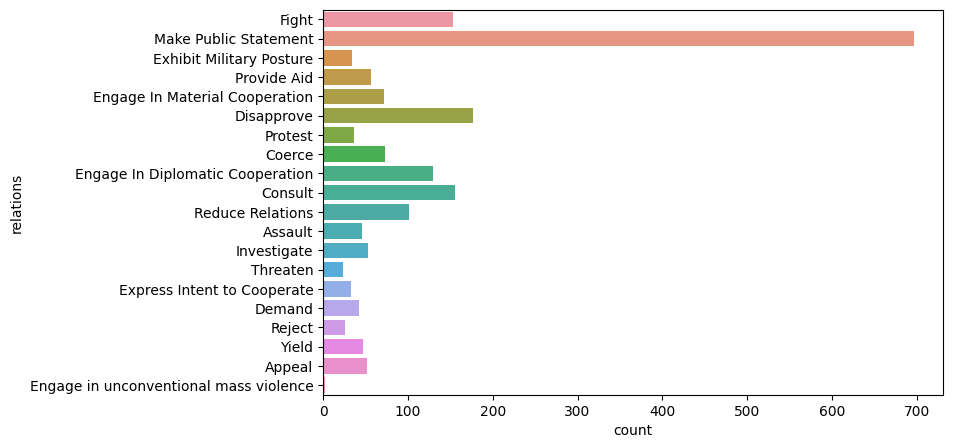

In [21]:
#enlargen dataframe so we have one row per relation instead of text with multiple relations
expl = data.explode("relations")
fig = plt.figure(figsize = (8,5))
sns.countplot(y = expl.relations);
#the data experiences a strong inbalance 
#the relation "engage in unconventional mass violence" was not used at all

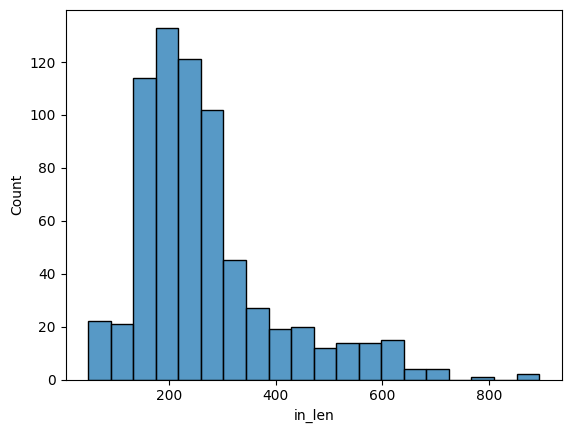

(180.25, 234.5, 304.0)

In [21]:
sns.histplot(data.in_len, bins = 20)
plt.show()
np.percentile(data.in_len, 25), np.percentile(data.in_len, 50), np.percentile(data.in_len, 75)

In [22]:
#also extract the length of the sentence and categorize it
def cat_len(text_len):
    if text_len < np.percentile(data.in_len, 25):
        return 1
    elif text_len < np.percentile(data.in_len, 50):
        return 2
    elif text_len < np.percentile(data.in_len, 75):
        return 3
    else:
        return 4

data["len_cat"] = data.in_len.apply(cat_len)
data

,doc_id,text,triplets,rel_count,prop,len,new_len,in_len,relations,rel_len,len_cat
0,0,Ukraine war: Russian tactics on eastern front ...,<triplet> Russian <subj> Ukraine <obj> Fight <...,4,False,4,4,164,"[Fight, Make Public Statement, Fight, Exhibit ...",4,1
1,2,Lee Jae-yong: Samsung appoints Lee Jae-yong to...,<triplet> presidential pardon <subj> Lee Jae-y...,2,False,2,2,157,"[Provide Aid, Engage In Material Cooperation]",2,1
2,3,New Zealand Instagram couple 'relieved' after ...,<triplet> New Zealand Instagram couple <subj> ...,1,True,1,1,174,[Disapprove],1,1
3,4,Iran protests: Police fire on Mahsa Amini mour...,<triplet> Police <subj> Mahsa Amini mourners <...,2,True,2,2,171,"[Fight, Protest]",2,1
4,5,Germany plans to legalise recreational cannabi...,<triplet> Germany <subj> recreational cannabis...,1,False,1,1,144,[Make Public Statement],1,1
...,...,...,...,...,...,...,...,...,...,...,...
740,4242,Delhi murder: India minister denigrates women ...,<triplet> India minister <subj> women <obj> Di...,2,False,2,2,164,"[Disapprove, Disapprove]",2,1
741,3394,Bomb attack on major Istanbul street kills six...,<triplet> Bomb attack <subj> major Istanbul st...,4,False,4,4,294,"[Assault, Assault, Assault, Assault]",4,3
742,1556,IAEA finds no indications of undeclared nuclea...,<triplet> IAEA <subj> Ukraine <obj> Make Publi...,4,False,4,4,329,"[Make Public Statement, Make Public Statement,...",4,4
743,3487,Xi tells Biden US and China should respect eac...,<triplet> Xi <subj> US <obj> Appeal <triplet> ...,2,False,2,2,318,"[Appeal, Appeal]",2,4


In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(data["relations"])#,"len","len_cat"])

In [32]:
cols = [f"rel{i}" for i in range(len(accept_MLB[0]))]
data2 = pd.concat([data.reset_index(), pd.DataFrame(accept_MLB, columns = cols)], axis = 1)

In [103]:
#select indexes for train & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(data2.text) * 0.85), train_size= (len(data2.text) - round(len(data2.text) * 0.85)), random_state = 1)
val_idx, train_idx = next(splits.split(data2.text, data2[cols]))

train = data2.iloc[train_idx]
tr_2 = pd.concat([train,train])
tr_3 = pd.concat([tr_2, tr_2])
tr_4 = pd.concat([tr_3, tr_3])
pre_split = data2.iloc[val_idx]

#select indexes test & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(pre_split.text) * 0.5), train_size= (len(pre_split.text) - round(len(pre_split.text) * 0.5)), random_state = 11)
#0,4 works decent
val_idx, test_idx = next(splits.split(pre_split.text, pre_split[cols]))

val = pre_split.iloc[val_idx]
test = pre_split.iloc[test_idx]

<AxesSubplot: xlabel='len_cat', ylabel='count'>

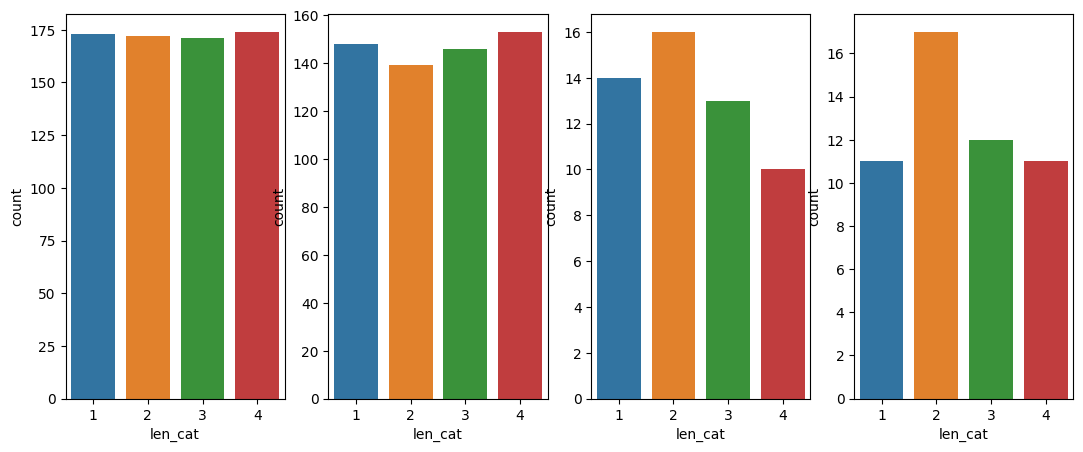

In [104]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (13,5))

sns.countplot(data = data2, x = "len_cat", ax = ax[0])
sns.countplot(data = train, x = "len_cat", ax = ax[1])
sns.countplot(data = val, x = "len_cat", ax = ax[2])
sns.countplot(data = test, x = "len_cat", ax = ax[3])

<AxesSubplot: xlabel='len', ylabel='count'>

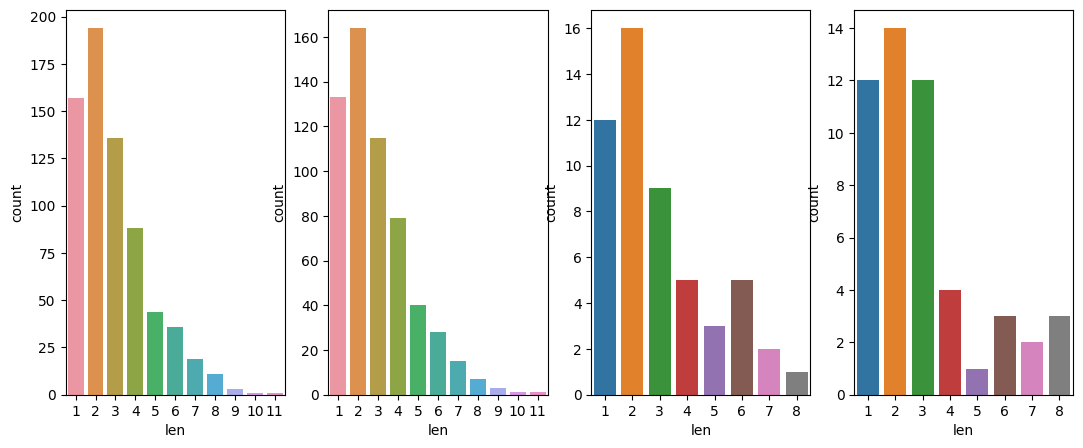

In [105]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (13,5))

sns.countplot(data = data2, x = "len", ax = ax[0])
sns.countplot(data = train, x = "len", ax = ax[1])
sns.countplot(data = val, x = "len", ax = ax[2])
sns.countplot(data = test, x = "len", ax = ax[3])

In [38]:
train.in_len.mean(), val.in_len.mean(), test.in_len.mean()

(266.5549828178694, 295.92, 252.25862068965517)

In [24]:
tr = train.explode("relations").groupby("relations").text.count().reset_index()
tr["text"] = tr.text.apply(lambda x: x / train.explode("relations").shape[0])
tr.columns = ["relations","train"]

vali= val.explode("relations").groupby("relations").text.count().reset_index()
vali["text"] = vali.text.apply(lambda x: x / val.explode("relations").shape[0])
vali.columns = ["relations","val"]

testi= test.explode("relations").groupby("relations").text.count().reset_index()
testi["text"] = testi.text.apply(lambda x: x / test.explode("relations").shape[0])
testi.columns = ["relations","testi"]

In [25]:
tr.merge(vali, on = "relations").merge(testi, on = "relations")

,relations,train,val,testi
0,Appeal,0.026377,0.019355,0.026846
1,Assault,0.024033,0.019355,0.013423
2,Coerce,0.036928,0.038710,0.026846
3,Consult,0.077960,0.070968,0.080537
4,Demand,0.020516,0.019355,0.026846
5,Disapprove,0.087925,0.090323,0.087248
6,Engage In Diplomatic Cooperation,0.062720,0.083871,0.067114
7,Engage In Material Cooperation,0.035170,0.038710,0.040268
8,Exhibit Military Posture,0.015826,0.025806,0.020134
9,Express Intent to Cooperate,0.015826,0.019355,0.020134


# IAA

In [4]:
read = pd.read_json("raw/out_label/summaries_felix.json", lines = True)
df_f = read[read.answer == "accept"]
df_f.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,"Sensible America finally spoke, but ‘Trumpty D...",3159,2108892512,770305806,False,"[{'start': 0, 'end': 16, 'token_start': 0, 'to...","[{'text': 'Sensible', 'start': 0, 'end': 8, 'i...",relations,"[{'head': 17, 'child': 22, 'head_span': {'star...",accept,1672048142
1,How Was Russia Able to Launch Russia's Biggest...,4317,-1406124216,-723512353,False,"[{'start': 8, 'end': 14, 'token_start': 2, 'to...","[{'text': 'How', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 2, 'child': 12, 'head_span': {'start...",accept,1672048306
2,World leaders discuss climate change solutions...,2396,-2130737925,1317932275,False,"[{'start': 0, 'end': 13, 'token_start': 0, 'to...","[{'text': 'World', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 1, 'child': 7, 'head_span': {'start'...",accept,1672048623
3,"In Colombia, Drilling Pays the Bills. Colombia...",3831,-534305385,-1860660404,False,"[{'start': 3, 'end': 11, 'token_start': 1, 'to...","[{'text': 'In', 'start': 0, 'end': 2, 'id': 0,...",relations,"[{'head': 9, 'child': 13, 'head_span': {'start...",accept,1672048776
4,Photo: Mohamed Salah shares image of Mohamed S...,1188,343647075,791917291,False,"[{'start': 7, 'end': 20, 'token_start': 2, 'to...","[{'text': 'Photo', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 51, 'child': 46, 'head_span': {'star...",accept,1672049094


In [5]:
read = pd.read_json("raw/out_label/counter_annotate.json", lines = True)
df_c = read[read.answer == "accept"]
df_c.head()

,text,article_id,_input_hash,_task_hash,_is_binary,spans,tokens,_view_id,relations,answer,_timestamp
0,"Sensible America finally spoke, but ‘Trumpty D...",3159,2108892512,770305806,False,"[{'start': 68, 'end': 89, 'token_start': 15, '...","[{'text': 'Sensible', 'start': 0, 'end': 8, 'i...",relations,"[{'head': 17, 'child': 22, 'head_span': {'star...",accept,1672333765
1,How Was Russia Able to Launch Russia's Biggest...,4317,-1406124216,-723512353,False,"[{'start': 8, 'end': 14, 'token_start': 2, 'to...","[{'text': 'How', 'start': 0, 'end': 3, 'id': 0...",relations,"[{'head': 18, 'child': 21, 'head_span': {'star...",accept,1672333840
2,World leaders discuss climate change solutions...,2396,-2130737925,1317932275,False,"[{'start': 0, 'end': 13, 'token_start': 0, 'to...","[{'text': 'World', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 1, 'child': 7, 'head_span': {'start'...",accept,1672333863
3,"In Colombia, Drilling Pays the Bills. Colombia...",3831,-534305385,-1860660404,False,"[{'start': 38, 'end': 54, 'token_start': 8, 't...","[{'text': 'In', 'start': 0, 'end': 2, 'id': 0,...",relations,"[{'head': 9, 'child': 13, 'head_span': {'start...",accept,1672333943
4,Photo: Mohamed Salah shares image of Mohamed S...,1188,343647075,791917291,False,"[{'start': 7, 'end': 20, 'token_start': 2, 'to...","[{'text': 'Photo', 'start': 0, 'end': 5, 'id':...",relations,"[{'head': 51, 'child': 46, 'head_span': {'star...",accept,1672049094


In [6]:
df_f.shape, df_c.shape

((46, 11), (46, 11))

In [7]:
df_fe = preprocess_raw(df_f)
df_co = preprocess_raw(df_c)

In [8]:
new = []
for row in df_fe.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])         
        
df_fel = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [9]:
new = []
for row in df_co.iterrows():

    split = re.split("<\w*>", row[1]["triplets"])[1:]       #first one is empty
    for i in range(int(len(split)/3)):                      #always pairs of 3
        sub_split = split[i*3:i*3+3]
        sub_split = [sub.rstrip().lstrip() for sub in sub_split]
        if [row[1]["doc_id"], sub_split,
         [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()],
          sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()] not in new: #remove duplicate triplets
            new.append([row[1]["doc_id"], sub_split, [sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip()], 
            sub_split[0].lstrip().rstrip(), sub_split[1].lstrip().rstrip(), sub_split[2].lstrip().rstrip()])            
        
df_cou = pd.DataFrame(new, columns = ["id","split", "ents", "subj", "obj", "rels"])

In [10]:
df_fel.shape, df_cou.shape

((153, 6), (137, 6))

In [11]:
#check if the two sets contain exactly same articles
df_cou.id.unique() == df_fel.id.unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [31]:
#agreement for entities
tp = 0
fp = 0
fn = 0
exact = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["ents"] in df_c_id.ents.to_list():
            tp += 1
            exact.append([row[1]["subj"], row[1]["obj"]])
        else:
            fp += 1
    fn = df_cou.shape[0] - tp

In [32]:
tp, fp, fn

(101, 52, 36)

In [34]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6601307189542484, 0.7372262773722628, 0.696551724137931)

In [35]:
#relaxed agreement for entities
tp = len(exact)
c = 0
tp_1 = 0
tp_2 = 0
fp = 0
fn = 0
found_l = []

found_l_3 = []

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_c_id.copy().reset_index()
    for row in df_f_id.iterrows():
        if row[1]["subj"] in df_c_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_1 += 1
                        found += 1

                        found_l.append([row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj])
                        found_l.append([rel.subj.iloc[idx], obj, row[1]["subj"],row[1]["obj"]])

                        found_l_3.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break


found_l_2 = []

for id in df_cou.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    sub = df_f_id.copy().reset_index()
    for row in df_c_id.iterrows():
        if row[1]["subj"] in df_f_id.subj.to_list():
            sub["relevant"] = sub.subj.apply(lambda x: row[1]["subj"] in x)
            rel = sub[sub.relevant == True]
            found = 0
            for idx, obj in enumerate(rel.obj.to_list()):
                if row[1]["obj"] in obj and [row[1]["subj"],row[1]["obj"], rel.subj.iloc[idx], obj] not in found_l:
                    if [row[1]["subj"], row[1]["obj"]] not in exact:
                        tp_2 += 1
                        found += 1
            
                        found_l_2.append([[row[1]["subj"],row[1]["obj"],row[1]["rels"]],[rel.subj.iloc[idx], obj, rel["rels"].iloc[idx]]])
                    break

fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1
tp = tp + tp_1 + tp_2

In [36]:
tp, fp, fn
#156, 136

(115, 38, 22)

In [37]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7516339869281046, 0.8394160583941606, 0.7931034482758621)

In [18]:
import collections

In [38]:
#agreement for relation classification
#with found relations in sentence -> overlap
tp = 0
fp = 0
fn = 0

for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id].rels
    df_c_id = df_cou[df_cou.id == id].rels

    f = collections.Counter(df_f_id.to_list())
    c = collections.Counter(df_c_id.to_list())

    tp += len(list((f & c).elements()))
    fp += len(list((f - c).elements()))
    fn += len(list((c - f).elements()))

In [39]:
tp, fp, fn

(109, 44, 28)

In [40]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7124183006535948, 0.7956204379562044, 0.7517241379310345)

In [41]:
#agreement for full relations
tp = 0
fp = 0
fn = 0

fix_list = []
good_list = []
for id in df_fel.id.unique():
    df_f_id = df_fel[df_fel.id == id]
    df_c_id = df_cou[df_cou.id == id]
    for row in df_f_id.iterrows():
        if row[1]["split"] in df_c_id.split.to_list():
            tp += 1
            #good_list.append([row[1]["id"], row[1]["split"]])
        else:
            fp += 1
            fix_list.append([row[1]["id"], row[1]["split"]])
    for row in df_c_id.iterrows():
        if row[1]["split"] not in df_f_id.split.to_list():
            fn += 1

In [42]:
tp, fp, fn

(90, 63, 47)

In [45]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.5882352941176471, 0.656934306569343, 0.6206896551724138)

In [46]:
#agreement for relation with relaxed entities
tp_exact = tp #exact matches
tp_1 = 0
tp_2 = 0

for row in found_l_3:       #taken from fuzzy entity matches
    if row[0][2] == row[1][2]:
        tp_1 += 1
for row in found_l_2:
    if row[0][2] == row[1][2]:
        tp_2 += 1

tp_rel = tp_exact + tp_1 + tp_2
fp = df_fel.shape[0] - (tp + tp_1) - tp_2
fn = df_cou.shape[0] - (tp + tp_2) - tp_1

In [47]:
tp, tp_1, tp_2, fp, fn, tp_rel

(90, 5, 5, 53, 37, 100)

In [48]:
precision = tp_rel / (fp + tp_rel)
recall = tp_rel / (fn + tp_rel)
f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.6535947712418301, 0.7299270072992701, 0.6896551724137931)